![image](https://raw.githubusercontent.com/IBM/watsonx-ai-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx.ai Text Extraction V2 service to extract text from file

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.


## Notebook content

This notebook contains the steps and code demonstrating how to run a Text Extraction job using Python SDK and then retrieve the results in the form of JSON, Markdown, HTML and image files.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goal

The purpose of this notebook is to demonstrate the usage a Text Extraction service and `ibm-watsonx-ai` Python SDK to retrieve a text from file that is located at IBM Cloud Object Storage.


## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [COS connection](#cos_connection)
- [Text Extraction request](#text_extraction)
- [Results examination](#results)
- [Summary](#summary)

<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).

### Install required packages

In [2]:
%pip install wget | tail -n 1
%pip install "ibm-watsonx-ai>=1.3.13" | tail -n 1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Defining the watsonx.ai credentials
This cell defines the watsonx.ai credentials required to work with watsonx Foundation Model inferencing.

**Action:** Provide the IBM Cloud user API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">documentation</a>.

In [3]:
import getpass

location = "jp-tok"
api_key = "your IBM Cloud API Key"

In [4]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    url=f"https://{location}.ml.cloud.ibm.com",
    api_key=api_key,
)

### Defining the project ID
The Text Extraction service requires project id that provides the context for the call. We will obtain the id from the project in which this notebook runs. Otherwise, please provide the project ID.

In [5]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")

### API Client initialization

In [6]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials=credentials, project_id=project_id)

<a id="cos_connection"></a>
## Create data connections with source document and results reference

テキスト抽出を実施する対象として、IBM Object Storageに保存したファイルを参照します。

### Create connection to COS

You can skip this section if you already have connection asset with IBM Cloud Object Storage.

In [8]:
datasource_name = "bluemixcloudobjectstorage"
bucket_name = "your COS bucket name"

In [9]:
cos_credentials = {
    "endpoint_url": "s3.jp-tok.cloud-object-storage.appdomain.cloud",
    "apikey": "your IBM Cloud API Key",
    "access_key_id": "your access key id",
    "secret_access_key": "your secret access key",
}

connection_meta_props = {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to {bucket_name} bucket",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_id_by_name(datasource_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: f"Connection to external bucket: {bucket_name}",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        "bucket": bucket_name,
        "access_key": cos_credentials["access_key_id"],
        "secret_key": cos_credentials["secret_access_key"],
        "url": cos_credentials["endpoint_url"],
    }
}

connection_details = client.connections.create(meta_props=connection_meta_props)
connection_asset_id = client.connections.get_id(connection_details)

Creating connections...
SUCCESS


### Create text extraction document reference and result references

In [10]:
from ibm_watsonx_ai.helpers import DataConnection, S3Location

# 既存のバケット名とファイルパスを指定
file_path = "your file name"  # 例: バケット直下の場合

document_reference = DataConnection(
    connection_asset_id=connection_asset_id,
    location=S3Location(bucket=bucket_name, path=file_path)
)

In [11]:
from ibm_watsonx_ai.helpers import DataConnection, S3Location

results_reference = DataConnection(
    connection_asset_id=connection_asset_id,
    location=S3Location(bucket=bucket_name, path="text_extraction_result/") # Must end with / 
)

<a id="text_extraction"></a>
## Text Extraction request preparation

Since data connection for source and results files are ready, we can proceed to the text extraction run job step. To initialize Text Extraction manager we use `TextExtractions` class.

In [43]:
from ibm_watsonx_ai.foundation_models.extractions import TextExtractionsV2

extraction = TextExtractionsV2(api_client=client, project_id=project_id)

### Define Text Extraction parameters

When running a job, the parameters for the text extraction pipeline can be specified. For more details about available parameters see [documentation](https://cloud.ibm.com/apidocs/watsonx-ai#text-extraction). The list of parameters available in SDK can be found below.

In [44]:
from ibm_watsonx_ai.metanames import TextExtractionsV2ParametersMetaNames

TextExtractionsV2ParametersMetaNames().show()

------------------------  ----  --------
META_PROP NAME            TYPE  REQUIRED
MODE                      str   N
OCR_MODE                  str   N
LANGUAGES                 list  N
AUTO_ROTATION_CORRECTION  bool  N
CREATE_EMBEDDED_IMAGES    str   N
OUTPUT_DPI                int   N
KVP_MODE                  str   N
OUTPUT_TOKENS_AND_BBOX    bool  N
------------------------  ----  --------


In our example we are going to use the following parameters:

In [56]:
parameters = {
    TextExtractionsV2ParametersMetaNames.MODE: "high_quality", #抽出の品質を設定
    TextExtractionsV2ParametersMetaNames.OCR_MODE: "enabled", #画像からテキストを抽出する
    TextExtractionsV2ParametersMetaNames.LANGUAGES: ["ja"],
    TextExtractionsV2ParametersMetaNames.AUTO_ROTATION_CORRECTION: True,
    TextExtractionsV2ParametersMetaNames.CREATE_EMBEDDED_IMAGES: "enabled_text", #画像を抽出する際のモードを指定する
    TextExtractionsV2ParametersMetaNames.OUTPUT_DPI: 72,
    TextExtractionsV2ParametersMetaNames.KVP_MODE: "invoice", #Key Value Pairの抽出モード、ドキュメントの種別を指定する
}

## Run extraction job for single return format
In order to run an extraction job, where only a single output format is requested, the `result_formats` parameter must be specified using the `TextExtractionsV2ResultFormats` enum. In our example we will use the `TextExtractionsV2ResultFormats.MARKDOWN` format.

In [57]:
from ibm_watsonx_ai.foundation_models.extractions import TextExtractionsV2ResultFormats


single_format_job_details = extraction.run_job(
    document_reference=document_reference,
    results_reference=results_reference,
    parameters=parameters,
    result_formats=TextExtractionsV2ResultFormats.MARKDOWN
)

single_format_job_details

{'metadata': {'id': '3fad03e3-69e4-42ef-9d33-de294c76f67a',
  'created_at': '2025-07-09T03:23:09.511Z',
  'project_id': '2a49c7fc-3c9a-404e-b637-3d0fbde16a37'},
 'entity': {'document_reference': {'type': 'connection_asset',
   'connection': {'id': '4b36cbb3-af8b-4db8-b808-c7ae0d82a411'},
   'location': {'bucket': '20250703-donotdelete-pr-0jnpyla0weudsc',
    'file_name': 'keisansho.pdf'}},
  'results_reference': {'type': 'connection_asset',
   'connection': {'id': '4b36cbb3-af8b-4db8-b808-c7ae0d82a411'},
   'location': {'bucket': '20250703-donotdelete-pr-0jnpyla0weudsc',
    'file_name': 'text_extraction_result/'}},
  'parameters': {'requested_outputs': ['md'],
   'mode': 'high_quality',
   'ocr_mode': 'enabled',
   'languages': ['ja'],
   'auto_rotation_correction': True,
   'create_embedded_images': 'enabled_text',
   'output_dpi': 72,
   'output_tokens_and_bbox': True,
   'kvp_mode': 'invoice'},
  'results': {'status': 'submitted', 'number_pages_processed': 0}}}

In [58]:
single_format_extraction_job_id = extraction.get_job_id(extraction_details=single_format_job_details)

We can list text extraction jobs using the list method.

In [62]:
extraction.list_jobs()

,EXTRACTION_JOB_ID,CREATED,STATUS
0,0f319a9b-3345-48af-a0d4-8f900e2e0541,2025-07-03T08:19:48.553Z,failed
1,3fad03e3-69e4-42ef-9d33-de294c76f67a,2025-07-09T03:23:09.511Z,completed
2,337c2d0b-fe56-4553-b6e0-9e1af5c38666,2025-07-09T02:33:32.542Z,completed
3,a58213ed-3250-4a93-828f-ea7ea1035a21,2025-07-03T08:17:16.441Z,failed
4,e10c1139-139d-4a37-bde2-61a7c0438ec8,2025-07-09T03:10:15.959Z,completed
5,114c0ac0-dbef-4b95-b210-52692508ea15,2025-07-04T08:23:54.325Z,completed
6,f62afcdf-a172-41e1-966b-c83c4a4f807d,2025-07-04T08:35:30.152Z,completed
7,ac839b9f-205d-4e26-aed0-19a8bb411ead,2025-07-03T05:12:50.938Z,completed
8,15c68030-e52b-4e63-ab0b-1497c40e8da2,2025-07-03T05:10:27.689Z,completed
9,49eb98a1-f4cf-4214-b730-ae7f4313649e,2025-07-04T08:37:29.923Z,completed


Moreover, to get details of a particular text extraction request, run the following:

In [63]:
extraction.get_job_details(extraction_job_id=single_format_extraction_job_id)

{'entity': {'document_reference': {'connection': {'id': '4b36cbb3-af8b-4db8-b808-c7ae0d82a411'},
   'location': {'bucket': '20250703-donotdelete-pr-0jnpyla0weudsc',
    'file_name': 'keisansho.pdf'},
   'type': 'connection_asset'},
  'parameters': {'auto_rotation_correction': True,
   'create_embedded_images': 'enabled_text',
   'kvp_mode': 'invoice',
   'languages': ['ja'],
   'mode': 'high_quality',
   'ocr_mode': 'enabled',
   'output_dpi': 72,
   'output_tokens_and_bbox': True,
   'requested_outputs': ['md']},
  'results': {'completed_at': '2025-07-09T03:23:56.771Z',
   'location': ['text_extraction_result/assembly.md',
    'text_extraction_result/embedded_images_assembly/*.png'],
   'number_pages_processed': 24,
   'running_at': '2025-07-09T03:23:13.957Z',
   'status': 'completed'},
  'results_reference': {'connection': {'id': '4b36cbb3-af8b-4db8-b808-c7ae0d82a411'},
   'location': {'bucket': '20250703-donotdelete-pr-0jnpyla0weudsc',
    'file_name': 'text_extraction_result/'},
  

To wait until the text extraction job completes, run the following cell:

In [64]:
import time

while True:
    time.sleep(5)

    job_details = extraction.get_job_details(extraction_job_id=single_format_extraction_job_id)
    job_status = job_details["entity"]["results"]["status"]
    if job_status != "running":
        print("\n", job_status, sep="")
        break

    print(".", sep="", end="", flush=True)


completed


Furthermore, to delete text extraction job run use `delete_job()` method.

### Results examination
Once the job extraction is completed, we can use the `get_results_reference` method to create the results data connection.

In [65]:
single_results_reference = extraction.get_results_reference(single_format_extraction_job_id)
single_results_reference

{'type': 'connection_asset', 'connection': {'id': '4b36cbb3-af8b-4db8-b808-c7ae0d82a411'}, 'location': {'bucket': '20250703-donotdelete-pr-0jnpyla0weudsc', 'file_name': 'text_extraction_result/'}}

Download the file to the result path.

In [66]:
single_result_dir = "single_text_extraction_results"
single_results_reference.download_folder(local_dir=single_result_dir)

After a successful download, it's possible to read the file content.

In [67]:
with open(f"{single_result_dir}/assembly.md") as file:
    extracted_text = file.read(1000)

print(extracted_text)

経済産業省 関東経済産業局



## 2024年度関東経済産業局委託事業

## 中堅・中小企業とスタートアップの



## 連携による価値創造チャレンジ事業

SAmKE 暮らしを 食で包む GD220 HS604 狙ったDNAを見える化し、 遺伝 潜在的なリスクを素早<察知する ! チップのサイズ : 45 mm x 25 mm 分注部 排出口 混合部 電気トモグラフィ(ET)法を用いた 製造プロセスの視える化 マイクロ流路 導入口 多項目同時遺伝子検査チップ

1 年間取り組み 先行研究における1年間 MCI の疑い し で健常脳に戻った人の最 高は49.7% 76.4%健常脳へ MCIを放っておくと 健常脳 | 認知症への移行車 1年で10%、5年で50%以」 90%以上維持ˊ 健常者 MCI 中度 非認知症 認知症

課題背景

* Go-Tech事業及びサポイン事業の活用企業(以下、「Go-Tech企業等」という。)などの成長意欲の高い中堅・ 中小企業に対して、異分野・新領域において革新的な技術やアイデアを有するスタートアップとのマッチン グ機会を提供し、既存事業の成長と新市場創出の両立を図る「両利きの経営」の実践を促すとともに、地域 支援機関に対して連携手法・ノウハウ等の横展開を図ることで、地域における中堅・中小企業の成長に資す ることを目的とする。

* 近年はDX・GX、先端技術を巡る経済対立等の不確実性要因の高まりにより、世界規模でのサプライチェー ン再編が懸念される。こうした事業環境下においては、いわゆる下請取引のみならず、既存の事業分野・領 域だけに依存しない新市場を創出していくことが重要となる。

* そのためには、自社に存在する知を磨き、技術・サービスの改善・高度化を図る「知の深化」だけでなく、 自社の知と社外にある知を組み合わせることで、新たな技術・サービスを開発し、新市場の創出を目指す「知 の探索」が不可欠となる。

* 「知の探索」においては、独創的な技術を有し、「イノベーションの担い手」と呼ばれるスタートアップと連  携することが有効な手段の一つである。しかし、中堅・中小企業を支援する自治体、産業支援機関、金融機 関において、中堅・中小企業とスタートアップとの連携の有効性やその連携手法等の広がりが十分でない。

## 

## Run extraction job for multiple file formats
In order to run an extraction job, where multiple output formats are requested, the `result_format` parameter must be specified using either a list of `TextExtractionsV2ResultFormats` enums (recommended) or a list of `str` instances. In our example we will use a list of the following file formats:

- `TextExtractionsV2ResultFormats.ASSEMBLY_JSON`
- `TextExtractionsV2ResultFormats.HTML`
- `TextExtractionsV2ResultFormats.PAGE_IMAGES`

In [27]:
multiple_formats_job_details = extraction.run_job(
    document_reference=document_reference,
    results_reference=results_reference,
    parameters=parameters,
    result_formats=[
        TextExtractionsV2ResultFormats.ASSEMBLY_JSON,
        TextExtractionsV2ResultFormats.HTML,
        TextExtractionsV2ResultFormats.PAGE_IMAGES,
    ]
)

multiple_formats_job_details

{'metadata': {'id': '337c2d0b-fe56-4553-b6e0-9e1af5c38666',
  'created_at': '2025-07-09T02:33:32.542Z',
  'project_id': '2a49c7fc-3c9a-404e-b637-3d0fbde16a37'},
 'entity': {'document_reference': {'type': 'connection_asset',
   'connection': {'id': '4b36cbb3-af8b-4db8-b808-c7ae0d82a411'},
   'location': {'bucket': '20250703-donotdelete-pr-0jnpyla0weudsc',
    'file_name': 'keisansho.pdf'}},
  'results_reference': {'type': 'connection_asset',
   'connection': {'id': '4b36cbb3-af8b-4db8-b808-c7ae0d82a411'},
   'location': {'bucket': '20250703-donotdelete-pr-0jnpyla0weudsc',
    'file_name': 'text_extraction_result/'}},
  'parameters': {'requested_outputs': ['assembly', 'html', 'page_images'],
   'mode': 'high_quality',
   'ocr_mode': 'enabled',
   'languages': ['ja'],
   'auto_rotation_correction': True,
   'create_embedded_images': 'enabled_placeholder',
   'output_dpi': 72,
   'output_tokens_and_bbox': True,
   'kvp_mode': 'invoice'},
  'results': {'status': 'submitted', 'number_pages_p

In [28]:
multiple_formats_extraction_job_id = extraction.get_job_id(extraction_details=multiple_formats_job_details)

We can list text extraction jobs using the list method.

In [36]:
extraction.list_jobs()

,EXTRACTION_JOB_ID,CREATED,STATUS
0,0f319a9b-3345-48af-a0d4-8f900e2e0541,2025-07-03T08:19:48.553Z,failed
1,337c2d0b-fe56-4553-b6e0-9e1af5c38666,2025-07-09T02:33:32.542Z,completed
2,a58213ed-3250-4a93-828f-ea7ea1035a21,2025-07-03T08:17:16.441Z,failed
3,114c0ac0-dbef-4b95-b210-52692508ea15,2025-07-04T08:23:54.325Z,completed
4,f62afcdf-a172-41e1-966b-c83c4a4f807d,2025-07-04T08:35:30.152Z,completed
5,ac839b9f-205d-4e26-aed0-19a8bb411ead,2025-07-03T05:12:50.938Z,completed
6,15c68030-e52b-4e63-ab0b-1497c40e8da2,2025-07-03T05:10:27.689Z,completed
7,49eb98a1-f4cf-4214-b730-ae7f4313649e,2025-07-04T08:37:29.923Z,completed
8,cb58efa5-92f7-471c-a0a1-e84e7b7dc34c,2025-07-09T02:29:41.703Z,completed


Moreover, to get details of a particular text extraction request, run the following:

To wait until the text extraction job completes, run the following cell:

In [37]:
import time

while True:
    time.sleep(5)

    job_details = extraction.get_job_details(extraction_job_id=multiple_formats_extraction_job_id)
    job_status = job_details["entity"]["results"]["status"]
    if job_status != "running":
        print("\n", job_status, sep="")
        break

    print(".", sep="", end="", flush=True)


completed


Furthermore, to delete text extraction job run use `delete_job()` method.

### Results examination
Once the job extraction is completed, we can use the `get_results_reference` method to create the results data connection.

In [38]:
multiple_results_reference = extraction.get_results_reference(multiple_formats_extraction_job_id)
multiple_results_reference

{'type': 'connection_asset', 'connection': {'id': '4b36cbb3-af8b-4db8-b808-c7ae0d82a411'}, 'location': {'bucket': '20250703-donotdelete-pr-0jnpyla0weudsc', 'file_name': 'text_extraction_result/'}}

In [39]:
multiple_results_dir = "multiple_text_extraction_results"
multiple_results_reference.download_folder(local_dir=multiple_results_dir)

After a successful download, it's possible to read the file contents.

In [40]:
import json

with open(f"{multiple_results_dir}/assembly.json") as file:
    extracted_assembly_json = json.load(file)

tokens = extracted_assembly_json["all_structures"]["tokens"]
result_text = " ".join(item["text"] for item in tokens)
print(result_text[:1000])

経済産業省 関東経済産業局 2024年度関東経済産業局委託事業 中堅・中小企業とスタートアップの 連携による価値創造チャレンジ事業 導入口 潜在的なリスクを素早<察知する ! 分注部 狙ったDNAを見える化し、 多項目同時遺伝子検査チップ チップのサイズ : 45 mm x 25 mm 混合部 マイクロ流路 排出口 遺伝 暮らしを 食で包む 電気トモグラフィ(ET)法を用いた 製造プロセスの視える化 SAmKE HS604 GD220 76.4%健常脳へ 90%以上維持ˊ 健常者 1 年間取り組み MCI の疑い し 健常脳 | 非認知症 MCI 1年で10%、5年で50%以」 先行研究における1年間 で健常脳に戻った人の最 高は49.7% MCIを放っておくと 認知症への移行車 認知症 中度 課題背景 ●Go-Tech事業及びサポイン事業の活用企業(以下、「Go-Tech企業等」という。)などの成長意欲の高い中堅・ 中小企業に対して、異分野・新領域において革新的な技術やアイデアを有するスタートアップとのマッチン グ機会を提供し、既存事業の成長と新市場創出の両立を図る「両利きの経営」の実践を促すとともに、地域 支援機関に対して連携手法・ノウハウ等の横展開を図ることで、地域における中堅・中小企業の成長に資す ることを目的とする。 ●近年はDX・GX、先端技術を巡る経済対立等の不確実性要因の高まりにより、世界規模でのサプライチェー ン再編が懸念される。こうした事業環境下においては、いわゆる下請取引のみならず、既存の事業分野・領 域だけに依存しない新市場を創出していくことが重要となる。 ●そのためには、自社に存在する知を磨き、技術・サービスの改善・高度化を図る「知の深化」だけでなく、 自社の知と社外にある知を組み合わせることで、新たな技術・サービスを開発し、新市場の創出を目指す「知 の探索」が不可欠となる。  ●「知の探索」においては、独創的な技術を有し、「イノベーションの担い手」と呼ばれるスタートアップと連 携することが有効な手段の一つである。しかし、中堅・中小企業を支援する自治体、産業支援機関、金融機 関において、中堅・中小企業とスタートアップとの連携の有効性やその連携手法等の広がりが十分でない。 中堅・中小企業の成長に寄与する新たな切り口 解決に向けた方向性

In [41]:
from IPython.core.display import display_html

with open(f"{multiple_results_dir}/assembly.html") as file:
    extracted_html = file.read()

display_html(extracted_html[:1000], raw=True)

2024年度関東経済産業局委託事業 
 中堅・中小企業とスタートアップの 
 連携による価値創造チャレンジ事業 
 
 Go-Tech事業及びサポイン事業の活用企業(以下、「Go-Tech企業等」という。)などの成長意欲の高い中堅・ 中小企業に対して、異分野・新領域において革新的な技術やアイデアを有するスタートアップとのマッチン グ機会を提供し、既存事業の成長と新市場創出の両立を図る「両利きの経営」の実践を促すとともに、地域 支援機関に対して連携手法・ノウハウ等の横展開を図ることで、地域における中堅・中小企業の成長に資す ることを目的とする。 
 近年はDX・GX、先端技術を巡る経済対立等の不確実性要因の高まりにより、世界規模でのサプライチェー ン再編が懸念される。こうした事業環境下においては、いわゆる下請取引のみならず、既存の事業分野・領 域だけに依存しない新市場を創出していくことが重要となる。 
 そのためには、自社に存在する知を磨き、技術・サービスの改善・高度化を図る「知の深化」だけでなく、 自社の知と社外にある知を組み合わせることで、新たな技術・サービスを開発し、新市場の創出を目指す「知 の探索」が不可欠となる。 
 「知の探索」においては、独創的な技術を有し、「イノベーションの担い手」と呼ばれるスタートアップと連  携することが有効な手段の一つである。しかし、中堅・中小企業を支援する自治体、産業支援機関、金融機 関において、中堅・中小企業とスタートアップとの連携の有効性やその連携手法等の広がりが十分でない。 
 
 中堅・中小企業の成長に寄与する新たな切り口 
 解決に向けた方向性 
 大手企業牽引のサプライチェーン（既存の事業領域( 
 価値創造活動の活発化（既存の事業領域＋新領域( 
 
 「大手企業牽引のサプライチェーン」に加えて、成長意欲の高い中堅・中小企業、地域未来牽引企業、Go Tech（旧サポイン）企業等）が、イノベーション力を秘めた異分野・新領域のスタートアップとのチャネルを 開拓し、バリューチェーンの構築を推進します。</

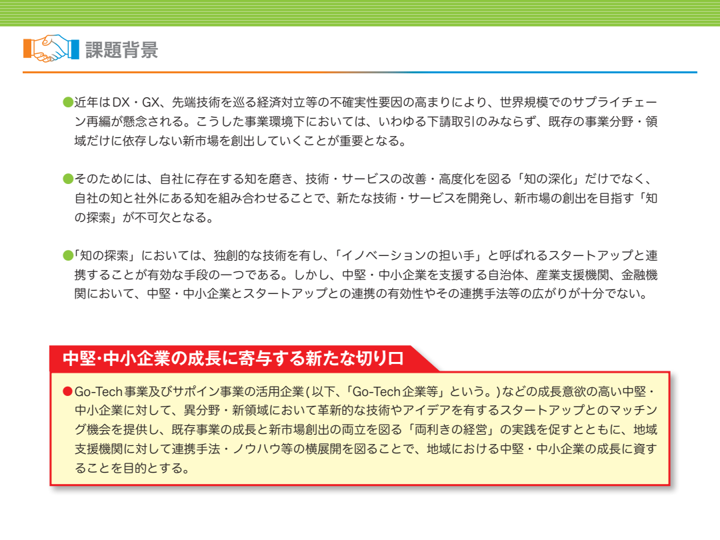

In [42]:
from IPython.core.display import display_png

with open(f"{multiple_results_dir}/page_images/1.png", "rb") as file:
    extracted_png = file.read()

display_png(extracted_png, raw=True)

<a id="summary"></a>
## Summary and next steps

 You successfully completed this notebook!
 
 You learned how to use `TextExtractionsV2` manager to run text extraction requests, check status of the submitted job and download a results file.
 
Check out our _<a href="https://ibm.github.io/watson-machine-learning-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors:
**Mateusz Świtała**, Software Engineer at watsonx.ai.

**Rafał Chrzanowski**, Software Engineer Intern at watsonx.ai.

Copyright © 2025 IBM. This notebook and its source code are released under the terms of the MIT License.